# IJCAI 2015 dataset preprocessing

This notebook provides an analysis of IJCAI 2015 Repeated buyers dataset and shows how it can be used in bandit problem.

IJCAI-15, a dataset used in the IJCAI competition 2015, provides a large number of user behavior logs of Tmall.com. This dataset contains the shopping logs of anonymous users within 6 months before and after the "Double Eleven” day. See <https://tianchi.aliyun.com/dataset/42> for more details. Importantly, the logs contain behavioral user feedback which includes 'click', 'add-to-cart', 'add-to-favorites', and 'purchase' events.

The original IJCAI competition 2015 offers a classification problem - to predict which shoppers would become repeat buyers after sales promotion. In order to recast this dataset to the learning from offline bandit feedback problem, we define `action` and pretend that action was recommended to a user and the signals we observe in the logs happened in the response to this action. Specifically, we consider 3 options for `action` based on this dataset: `item_id`, `cat_id`, `brand_id`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

import tqdm


C:\Users\provo501\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\multiclass.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.sparse.base import spmatrix
C:\Users\provo501\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\provo501\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.fl

In [2]:

user_info = pd.read_csv("data/IJCAI15/user_info_format1.csv")
print(user_info.shape)
user_info.head()

(424170, 3)


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [3]:

user_log = pd.read_csv("data/IJCAI15/user_log_format1.csv")
print(user_log.shape)
user_log.apply(lambda x: x.nunique())

(54925330, 7)


user_id         424170
item_id        1090390
cat_id            1658
seller_id         4995
brand_id          8443
time_stamp         186
action_type          4
dtype: int64

In [4]:

user_log[(user_log['user_id'] == 66012) & (user_log['item_id'] == 67897)]

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
1248,66012,67897,1349,184,1360.0,1111,0
1261,66012,67897,1349,184,1360.0,1111,0
1265,66012,67897,1349,184,1360.0,1109,0
1266,66012,67897,1349,184,1360.0,1109,0
1267,66012,67897,1349,184,1360.0,1109,0
1268,66012,67897,1349,184,1360.0,1109,0
1271,66012,67897,1349,184,1360.0,1109,3



# Top 10 `item_id` as actions

In [5]:

action_col = 'item_id'
k = 10
top_k_actions = user_log.groupby(action_col)[action_col].count().sort_values().index[-k:]

user_log_short = user_log[user_log[action_col].isin(top_k_actions)]
del user_log
print(user_log_short.shape)
user_log_short.apply(lambda x: x.nunique())

(807523, 7)


user_id        73151
item_id           10
cat_id             7
seller_id          7
brand_id           6
time_stamp       186
action_type        4
dtype: int64

In [6]:

df = user_log_short.groupby(['user_id', 'time_stamp', action_col])[['action_type']].value_counts()
df

user_id  time_stamp  item_id  action_type
11       1102        94609    0                1
14       701         631714   0                1
19       1111        67897    0                1
20       717         631714   0                1
22       1111        67897    0              426
                                            ... 
424155   714         631714   0                1
424162   1110        67897    0               10
                     783997   0                3
                     1024557  0                1
         1111        1059899  0                1
Length: 157556, dtype: int64

In [7]:

df = df.unstack(fill_value=0).rename(columns=int).add_prefix('signal_').reset_index()
df[~df['signal_2'].isna()]
df

action_type,user_id,time_stamp,item_id,signal_0,signal_1,signal_2,signal_3
0,11,1102,94609,1,0,0,0
1,14,701,631714,1,0,0,0
2,19,1111,67897,1,0,0,0
3,20,717,631714,1,0,0,0
4,22,1111,67897,426,0,0,0
...,...,...,...,...,...,...,...
137534,424155,714,631714,1,0,0,0
137535,424162,1110,67897,10,0,0,0
137536,424162,1110,783997,3,0,0,0
137537,424162,1110,1024557,1,0,0,0


In [8]:

df['date'] = pd.to_datetime('2014' + df['time_stamp'].apply(str), format='%Y%m%d')
df['dow'] = df['date'].dt.dayofweek
df = df.join(user_info.set_index('user_id'), on='user_id')
df.head()

,user_id,time_stamp,item_id,signal_0,signal_1,signal_2,signal_3,date,dow,age_range,gender
0,11,1102,94609,1,0,0,0,2014-11-02,6,4.0,1.0
1,14,701,631714,1,0,0,0,2014-07-01,1,6.0,0.0
2,19,1111,67897,1,0,0,0,2014-11-11,1,0.0,1.0
3,20,717,631714,1,0,0,0,2014-07-17,3,5.0,0.0
4,22,1111,67897,426,0,0,0,2014-11-11,1,4.0,1.0


In [9]:
# 0.0 and null correspond to unknown gender
df['age_range'] = df['age_range'].fillna(0.0)
# 2.0 and null correspond to unknown gender
df['gender'] = df['gender'].fillna(2.0)

In [10]:
df[df.isnull().any(axis=1)]

,user_id,time_stamp,item_id,signal_0,signal_1,signal_2,signal_3,date,dow,age_range,gender



## Analyze clicks (`Signal_0`)

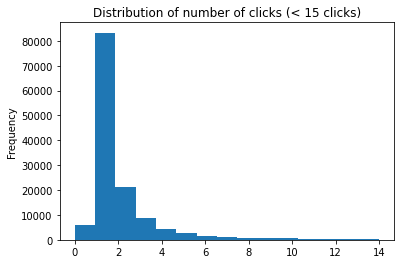

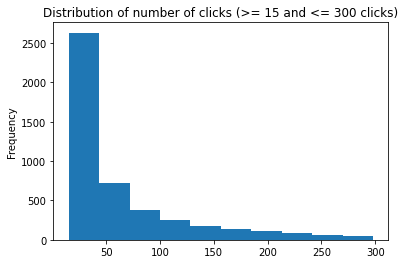

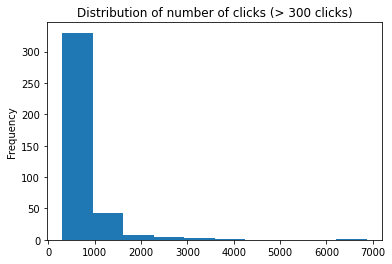

Number of observations with > 300 clicks: 389


In [11]:

df[(df['signal_0'] >= 0) & (df['signal_0'] < 15)]['signal_0'].plot(kind='hist', bins=15)
plt.title("Distribution of number of clicks (< 15 clicks)")
plt.show()

df[(df['signal_0'] >= 15) & (df['signal_0'] <= 300)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (>= 15 and <= 300 clicks)")
plt.show()

df[(df['signal_0'] > 300) & (df['signal_0'] < 10000)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (> 300 clicks)")
plt.show()

print(f"Number of observations with > 300 clicks: {df[(df['signal_0'] >= 300)].shape[0]}")


#### remove data points with more than 300 clicks in one session and consider `np.log(clicks +1)` instead of clicks

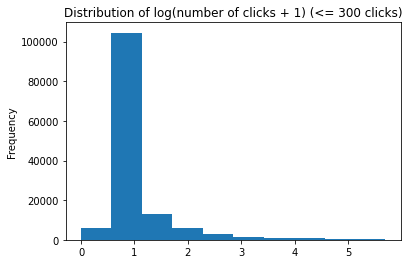

In [12]:

df = df[(df['signal_0'] < 300)]

df['log_signal_0'] = np.log(df['signal_0'] + 1)
df['log_signal_0'].plot(kind='hist')
plt.title("Distribution of log(number of clicks + 1) (<= 300 clicks)")
plt.show()


## Analyze add to cart (`signal_1`)

In [13]:

pd.concat([df['signal_1'].value_counts(), df['signal_1'].value_counts() / df.shape[0]], axis=1)

,signal_1,signal_1
0,136948,0.998527
1,195,0.001422
2,6,0.000044
3,1,0.000007



#### recast `signal_1` as binary

In [14]:

df['signal_1_binary'] = (df['signal_1'] > 0) * 1


## Analyze add to favorites (`signal_3`)

In [15]:

pd.concat([df['signal_3'].value_counts(), df['signal_3'].value_counts() / df.shape[0]], axis=1)

,signal_3,signal_3
0,121989,0.889457
1,15161,0.110543



#### do dummy operation (recast it is binary)

In [16]:

df['signal_3_binary'] = (df['signal_3'] > 0) * 1
pd.concat([df['signal_3_binary'].value_counts(),
           df['signal_3_binary'].value_counts() / df.shape[0]], axis=1)

,signal_3_binary,signal_3_binary
0,121989,0.889457
1,15161,0.110543



## Analyze purchases (`signal_2`)

In [17]:

pd.concat([df['signal_2'].value_counts(), df['signal_2'].value_counts() / df.shape[0]], axis=1)

,signal_2,signal_2
0,126574,0.922887
1,9636,0.070259
2,720,0.005250
3,148,0.001079
4,40,0.000292
5,20,0.000146
7,6,0.000044
6,5,0.000036
8,1,0.000007



#### recast it as binary

In [18]:

df['signal_2_binary'] = (df['signal_2'] > 0) * 1


## Analyze features

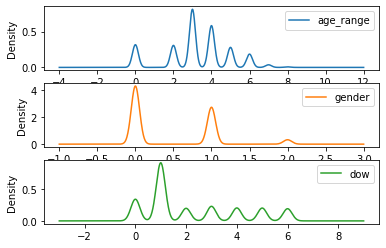

In [19]:

features = ['age_range', 'gender', 'dow']
df[features].plot(kind='density', subplots=True, layout=(len(features), 1), sharex=False)
plt.show()


#### do nothing with features


## Final dataset

In [20]:

proxies = ['log_signal_0', 'signal_1_binary', 'signal_3_binary']
target = ['signal_2_binary']
action = [action_col]
final_df = df[features + action + proxies + target]
final_df

,age_range,gender,dow,item_id,log_signal_0,signal_1_binary,signal_3_binary,signal_2_binary
0,4.0,1.0,6,94609,0.693147,0,0,0
1,6.0,0.0,1,631714,0.693147,0,0,0
2,0.0,1.0,1,67897,0.693147,0,0,0
3,5.0,0.0,3,631714,0.693147,0,0,0
5,4.0,1.0,1,94609,1.098612,0,0,0
...,...,...,...,...,...,...,...,...
137534,6.0,0.0,0,631714,0.693147,0,0,0
137535,4.0,0.0,0,67897,2.397895,0,0,0
137536,4.0,0.0,0,783997,1.386294,0,0,0
137537,4.0,0.0,0,1024557,0.693147,0,0,0


In [23]:
len(final_df[final_df.isnull().any(axis=1)]) == 0

0


## Check predictive power of features and proxies

In [19]:

def gini(var):
    df = final_df.copy()
    x_trn = df.loc[idx_trn, var]
    y_trn = df.loc[idx_trn, target[0]]
    x_tst = df.loc[idx_tst, var]
    y_tst = df.loc[idx_tst, target[0]]

    if x_trn.dtype in ['O','object']:
        cats = pd.DataFrame({'x': x_trn, 'y': y_trn}).fillna('#NAN#').groupby('x').agg('mean').sort_values('y').index.values
        X_trn = pd.Categorical(x_trn.fillna('#NAN#'), categories=cats, ordered=True).codes.reshape(-1, 1)
        X_tst = pd.Categorical(x_tst.fillna('#NAN#'), categories=cats, ordered=True).codes.reshape(-1, 1)
    else:
        repl = min(x_trn.min(), x_tst.min())-1 if np.isfinite(min(x_trn.min(), x_tst.min())-1) else -999999
        #repl = x_trn.min()-1 if np.isfinite(x_trn.min())-1 else -999999
        X_trn = x_trn.fillna(repl).replace(np.inf, repl).replace(-np.inf, repl).values.reshape(-1, 1)
        X_tst = x_tst.fillna(repl).replace(np.inf, repl).replace(-np.inf, repl).values.reshape(-1, 1)

    obvious_gini_trn = 2*roc_auc_score(y_trn, X_trn)-1
    obvious_gini_tst = 2*roc_auc_score(y_tst, X_tst)-1

    if obvious_gini_trn < 0:
        obvious_gini_trn = -obvious_gini_trn
        obvious_gini_tst = -obvious_gini_tst

    parameters = {'min_samples_leaf':[0.01, 0.025, 0.05, 0.1]}
    dt = DecisionTreeClassifier(random_state=1)
    clf = GridSearchCV(dt, parameters, cv=4, scoring='roc_auc', n_jobs=10)
    clf.fit(X_trn, y_trn)

    true_gini_trn = 2*clf.best_score_-1
    true_gini_tst = 2*roc_auc_score(y_tst, clf.predict_proba(X_tst)[:, 1])-1

    if true_gini_trn < 0:
        true_gini_trn = -true_gini_trn
        true_gini_tst = -true_gini_tst

    if obvious_gini_trn > true_gini_trn:
        return [var, obvious_gini_trn, obvious_gini_tst]
    else:
        return [var, true_gini_trn, true_gini_tst]

In [20]:

idx_trn, idx_tst = train_test_split(final_df.index, test_size=0.3, random_state=42,
                                     stratify=final_df[target])

In [24]:
var_cols = features + proxies + action
res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))

<ipython-input-24-89543f49a63e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))


  0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
res = pd.DataFrame(res)
res.set_index(0, inplace=True)
res.columns = ['gini_train', 'gini_test']
res

,gini_train,gini_test
0,,
age_range,0.059087,0.061818
gender,0.109973,0.117540
dow,0.286731,0.312103
log_signal_0,0.524713,0.537938
signal_1_binary,0.000255,-0.000793
signal_3_binary,0.080488,0.081684
item_id,0.475827,0.476496


#### `signal_1_binary` is probably not the best candidate for proxies


# Top 10 `cat_id` as actions

In [26]:
user_log = pd.read_csv("data/IJCAI15/user_log_format1.csv")

In [27]:
action_col = 'cat_id'
k = 10
top_k_actions = user_log.groupby(action_col)[action_col].count().sort_values().index[-k:]

user_log_short = user_log[user_log[action_col].isin(top_k_actions)]
del user_log
print(user_log_short.shape)
user_log_short.apply(lambda x: x.nunique())

(17233135, 7)


user_id        385458
item_id        265466
cat_id             10
seller_id        2009
brand_id         2317
time_stamp        186
action_type         4
dtype: int64

In [28]:
df = user_log_short.groupby(['user_id', 'time_stamp', action_col])[['action_type']].value_counts()
df

user_id  time_stamp  cat_id  action_type
1        1111        389     0               2
2        626         602     0              16
                             2               2
         817         737     0              18
                             2               1
                                            ..
424170   1107        656     0               6
         1108        656     0               6
         1111        602     0               7
                     656     0               1
                             2               1
Length: 5699353, dtype: int64

In [29]:
df = df.unstack(fill_value=0).rename(columns=int).add_prefix('signal_').reset_index()
df[~df['signal_2'].isna()]
df

action_type,user_id,time_stamp,cat_id,signal_0,signal_1,signal_2,signal_3
0,1,1111,389,2,0,0,0
1,2,626,602,16,0,2,0
2,2,817,737,18,0,1,0
3,2,1002,737,1,0,0,0
4,2,1108,389,0,0,0,1
...,...,...,...,...,...,...,...
4842827,424170,1106,656,6,0,0,0
4842828,424170,1107,656,6,0,0,0
4842829,424170,1108,656,6,0,0,0
4842830,424170,1111,602,7,0,0,0


In [30]:
df['date'] = pd.to_datetime('2014' + df['time_stamp'].apply(str), format='%Y%m%d')
df['dow'] = df['date'].dt.dayofweek
df = df.join(user_info.set_index('user_id'), on='user_id')
df.head()

,user_id,time_stamp,cat_id,signal_0,signal_1,signal_2,signal_3,date,dow,age_range,gender
0,1,1111,389,2,0,0,0,2014-11-11,1,3.0,1.0
1,2,626,602,16,0,2,0,2014-06-26,3,3.0,0.0
2,2,817,737,18,0,1,0,2014-08-17,6,3.0,0.0
3,2,1002,737,1,0,0,0,2014-10-02,3,3.0,0.0
4,2,1108,389,0,0,0,1,2014-11-08,5,3.0,0.0


## Analyze clicks (`Signal_0`)

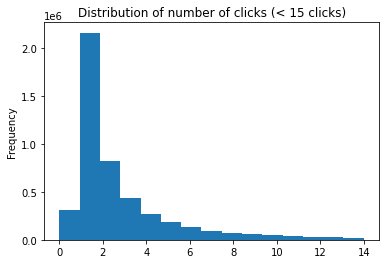

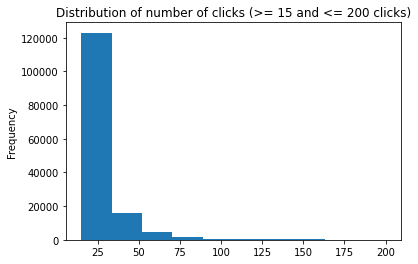

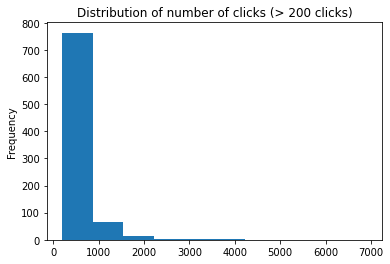

Number of observations with > 200 clicks: 858


In [31]:
df[(df['signal_0'] >= 0) & (df['signal_0'] < 15)]['signal_0'].plot(kind='hist', bins=15)
plt.title("Distribution of number of clicks (< 15 clicks)")
plt.show()

df[(df['signal_0'] >= 15) & (df['signal_0'] <= 300)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (>= 15 and <= 200 clicks)")
plt.show()

df[(df['signal_0'] > 300) & (df['signal_0'] < 10000)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (> 200 clicks)")
plt.show()

print(f"Number of observations with > 200 clicks: {df[(df['signal_0'] >= 200)].shape[0]}")

#### remove data points with more than 300 clicks in one session and consider `np.log(clicks +1)` instead of clicks

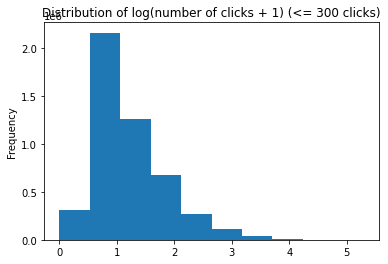

In [32]:
df = df[(df['signal_0'] < 300)]

df['log_signal_0'] = np.log(df['signal_0'] + 1)
df['log_signal_0'].plot(kind='hist')
plt.title("Distribution of log(number of clicks + 1) (<= 300 clicks)")
plt.show()

## Analyze add to cart (`signal_1`)

In [33]:
pd.concat([df['signal_1'].value_counts(), df['signal_1'].value_counts() / df.shape[0]], axis=1)

,signal_1,signal_1
0,4824757,9.964442e-01
1,14711,3.038224e-03
2,1858,3.837278e-04
3,435,8.983939e-05
4,126,2.602244e-05
5,49,1.011984e-05
6,16,3.304437e-06
7,9,1.858746e-06
8,3,6.195820e-07
10,3,6.195820e-07


#### recast `signal_1` as binary

In [34]:
df['signal_1_binary'] = (df['signal_1'] > 0) * 1

In [35]:
pd.concat([df['signal_1_binary'].value_counts(),
           df['signal_1_binary'].value_counts() / df.shape[0]], axis=1)

,signal_1_binary,signal_1_binary
0,4824757,0.996444
1,17217,0.003556


## Analyze add to favorites (`signal_3`)

In [36]:
pd.concat([df['signal_3'].value_counts(), df['signal_3'].value_counts() / df.shape[0]], axis=1)

,signal_3,signal_3
0,4128900,8.527307e-01
1,549630,1.135136e-01
2,102625,2.119487e-02
3,31844,6.576657e-03
4,13183,2.722650e-03
5,6392,1.320123e-03
6,3558,7.348243e-04
7,2044,4.221419e-04
8,1149,2.372999e-04
9,694,1.433300e-04


#### we will keep this `signal_3` but recast it as binary

In [37]:
df['signal_3_binary'] = (df['signal_3'] > 0) * 1
pd.concat([df['signal_3_binary'].value_counts(),
           df['signal_3_binary'].value_counts() / df.shape[0]], axis=1)

,signal_3_binary,signal_3_binary
0,4128900,0.852731
1,713074,0.147269


## Analyze purchases (`signal_2`)

In [38]:
pd.concat([df['signal_2'].value_counts(), df['signal_2'].value_counts() / df.shape[0]], axis=1)

,signal_2,signal_2
0,4404541,9.096581e-01
1,367131,7.582259e-02
2,55518,1.146598e-02
3,10289,2.124960e-03
4,3009,6.214408e-04
5,896,1.850485e-04
6,343,7.083888e-05
7,125,2.581592e-05
8,64,1.321775e-05
9,32,6.608875e-06


#### recast it as binary

In [39]:
df['signal_2_binary'] = (df['signal_2'] > 0) * 1
pd.concat([df['signal_2_binary'].value_counts(),
           df['signal_2_binary'].value_counts() / df.shape[0]], axis=1)

,signal_2_binary,signal_2_binary
0,4404541,0.909658
1,437433,0.090342


## Analyze features

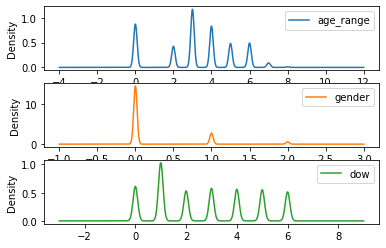

In [40]:
features = ['age_range', 'gender', 'dow']
df[features].plot(kind='density', subplots=True, layout=(len(features), 1), sharex=False)
plt.show()

#### do nothing with features

## Final dataset

In [41]:
proxies = ['log_signal_0', 'signal_1_binary', 'signal_3_binary']
target = ['signal_2_binary']
action = [action_col]
final_df = df[features + action + proxies + target]
final_df

,age_range,gender,dow,cat_id,log_signal_0,signal_1_binary,signal_3_binary,signal_2_binary
0,3.0,1.0,1,389,1.098612,0,0,0
1,3.0,0.0,3,602,2.833213,0,0,1
2,3.0,0.0,6,737,2.944439,0,0,1
3,3.0,0.0,3,737,0.693147,0,0,0
4,3.0,0.0,5,389,0.000000,0,1,0
...,...,...,...,...,...,...,...,...
4842827,0.0,1.0,3,656,1.945910,0,0,0
4842828,0.0,1.0,4,656,1.945910,0,0,0
4842829,0.0,1.0,5,656,1.945910,0,0,0
4842830,0.0,1.0,1,602,2.079442,0,0,0


## Check predictive power of features and proxies

In [42]:
idx_trn, idx_tst = train_test_split(final_df.index, test_size=0.3, random_state=42,
                                     stratify=final_df[target])

In [43]:
var_cols = features + proxies + action
res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))

<ipython-input-43-89543f49a63e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))


  0%|          | 0/7 [00:00<?, ?it/s]

In [44]:
res = pd.DataFrame(res)
res.set_index(0, inplace=True)
res.columns = ['gini_train', 'gini_test']
res

,gini_train,gini_test
0,,
age_range,0.018536,0.021340
gender,0.027109,0.024890
dow,0.350997,0.349487
log_signal_0,0.509078,0.509968
signal_1_binary,0.000595,0.000644
signal_3_binary,0.082847,0.084073
cat_id,0.207292,0.207219


#### probably `signal_1_binary` is not a good candidate for proxies


# Top 10 `brand_id` as actions

In [45]:
user_log = pd.read_csv("data/IJCAI15/user_log_format1.csv")

In [46]:
action_col = 'brand_id'
k = 10
top_k_actions = user_log.groupby(action_col)[action_col].count().sort_values().index[-k:]

user_log_short = user_log[user_log[action_col].isin(top_k_actions)]
del user_log
print(user_log_short.shape)
user_log_short.apply(lambda x: x.nunique())

(5391246, 7)


user_id        270875
item_id         36053
cat_id            169
seller_id         137
brand_id           10
time_stamp        186
action_type         4
dtype: int64

In [47]:
df = user_log_short.groupby(['user_id', 'time_stamp', action_col])[['action_type']].value_counts()
df

user_id  time_stamp  brand_id  action_type
2        1010        2276.0    2              2
3        727         1214.0    0              1
4        724         8235.0    0              1
5        814         3738.0    0              1
         1025        1662.0    0              3
                                             ..
424169   1014        4705.0    0              6
         1103        4705.0    0              1
         1106        3738.0    0              2
         1110        3738.0    0              1
         1111        1662.0    0              1
Length: 1420708, dtype: int64

In [48]:
df = df.unstack(fill_value=0).rename(columns=int).add_prefix('signal_').reset_index()
df[~df['signal_2'].isna()]
df

action_type,user_id,time_stamp,brand_id,signal_0,signal_1,signal_2,signal_3
0,2,1010,2276.0,0,0,2,0
1,3,727,1214.0,1,0,0,0
2,4,724,8235.0,1,0,0,0
3,5,814,3738.0,1,0,0,0
4,5,1025,1662.0,3,0,0,1
...,...,...,...,...,...,...,...
1195570,424169,1014,4705.0,6,0,0,0
1195571,424169,1103,4705.0,1,0,0,0
1195572,424169,1106,3738.0,2,0,0,0
1195573,424169,1110,3738.0,1,0,0,0


In [49]:
df['date'] = pd.to_datetime('2014' + df['time_stamp'].apply(str), format='%Y%m%d')
df['dow'] = df['date'].dt.dayofweek
df = df.join(user_info.set_index('user_id'), on='user_id')
df.head()

,user_id,time_stamp,brand_id,signal_0,signal_1,signal_2,signal_3,date,dow,age_range,gender
0,2,1010,2276.0,0,0,2,0,2014-10-10,4,3.0,0.0
1,3,727,1214.0,1,0,0,0,2014-07-27,6,3.0,0.0
2,4,724,8235.0,1,0,0,0,2014-07-24,3,0.0,0.0
3,5,814,3738.0,1,0,0,0,2014-08-14,3,5.0,0.0
4,5,1025,1662.0,3,0,0,1,2014-10-25,5,5.0,0.0


## Analyze clicks (`Signal_0`)

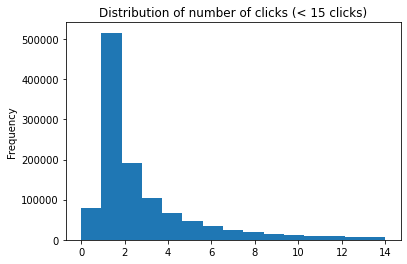

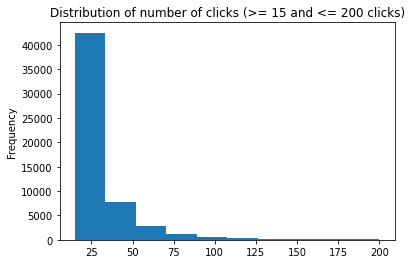

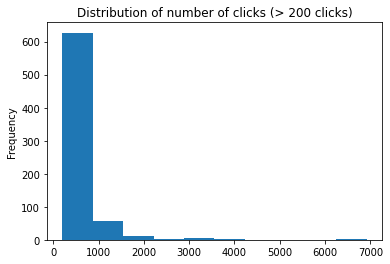

Number of observations with > 200 clicks: 709


In [50]:
df[(df['signal_0'] >= 0) & (df['signal_0'] < 15)]['signal_0'].plot(kind='hist', bins=15)
plt.title("Distribution of number of clicks (< 15 clicks)")
plt.show()

df[(df['signal_0'] >= 15) & (df['signal_0'] <= 300)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (>= 15 and <= 200 clicks)")
plt.show()

df[(df['signal_0'] > 300) & (df['signal_0'] < 10000)]['signal_0'].plot(kind='hist')
plt.title("Distribution of number of clicks (> 200 clicks)")
plt.show()

print(f"Number of observations with > 200 clicks: {df[(df['signal_0'] >= 200)].shape[0]}")

#### remove data points with more than 300 clicks in one session and consider `np.log(clicks +1)` instead of clicks

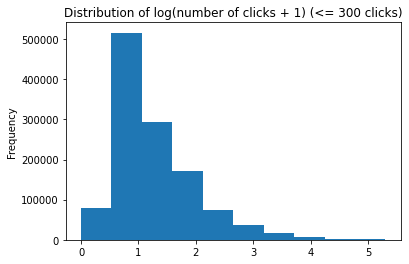

In [51]:
df = df[(df['signal_0'] < 300)]

df['log_signal_0'] = np.log(df['signal_0'] + 1)
df['log_signal_0'].plot(kind='hist')
plt.title("Distribution of log(number of clicks + 1) (<= 300 clicks)")
plt.show()

## Analyze add to cart (`signal_1`)

In [52]:
pd.concat([df['signal_1'].value_counts(), df['signal_1'].value_counts() / df.shape[0]], axis=1)

,signal_1,signal_1
0,1194864,0.999998
1,2,0.000002


#### recast `signal_1` as binary

In [53]:
df['signal_1_binary'] = (df['signal_1'] > 0) * 1

In [54]:
pd.concat([df['signal_1_binary'].value_counts(),
           df['signal_1_binary'].value_counts() / df.shape[0]], axis=1)

,signal_1_binary,signal_1_binary
0,1194864,0.999998
1,2,0.000002


## Analyze add to favorites (`signal_3`)

In [55]:
pd.concat([df['signal_3'].value_counts(), df['signal_3'].value_counts() / df.shape[0]], axis=1)

,signal_3,signal_3
0,1030308,8.622791e-01
1,119851,1.003050e-01
2,24526,2.052615e-02
3,9090,7.607548e-03
4,4264,3.568601e-03
5,2372,1.985160e-03
6,1415,1.184233e-03
7,908,7.599178e-04
8,550,4.603027e-04
9,398,3.330917e-04


#### we will keep this `signal_3` but recast it as binary

In [56]:
df['signal_3_binary'] = (df['signal_3'] > 0) * 1
pd.concat([df['signal_3_binary'].value_counts(),
           df['signal_3_binary'].value_counts() / df.shape[0]], axis=1)

,signal_3_binary,signal_3_binary
0,1030308,0.862279
1,164558,0.137721


## Analyze purchases (`signal_2`)

In [57]:
pd.concat([df['signal_2'].value_counts(), df['signal_2'].value_counts() / df.shape[0]], axis=1)

,signal_2,signal_2
0,1056290,8.840238e-01
1,97189,8.133883e-02
2,25044,2.095967e-02
3,8179,6.845119e-03
4,4200,3.515039e-03
5,2339,1.957542e-03
6,825,6.904540e-04
7,357,2.987783e-04
8,221,1.849580e-04
9,128,1.071250e-04


#### recast it as binary

In [58]:
df['signal_2_binary'] = (df['signal_2'] > 0) * 1
pd.concat([df['signal_2_binary'].value_counts(),
           df['signal_2_binary'].value_counts() / df.shape[0]], axis=1)

,signal_2_binary,signal_2_binary
0,1056290,0.884024
1,138576,0.115976


## Analyze features

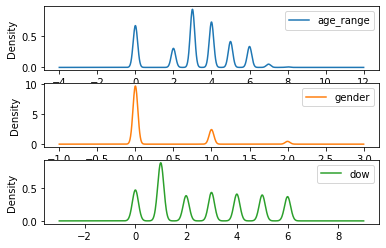

In [59]:
features = ['age_range', 'gender', 'dow']
df[features].plot(kind='density', subplots=True, layout=(len(features), 1), sharex=False)
plt.show()

#### do nothing with features

## Final dataset

In [60]:
proxies = ['log_signal_0', 'signal_1_binary', 'signal_3_binary']
target = ['signal_2_binary']
action = [action_col]
final_df = df[features + action + proxies + target]
final_df

,age_range,gender,dow,brand_id,log_signal_0,signal_1_binary,signal_3_binary,signal_2_binary
0,3.0,0.0,4,2276.0,0.000000,0,0,1
1,3.0,0.0,6,1214.0,0.693147,0,0,0
2,0.0,0.0,3,8235.0,0.693147,0,0,0
3,5.0,0.0,3,3738.0,0.693147,0,0,0
4,5.0,0.0,5,1662.0,1.386294,0,1,0
...,...,...,...,...,...,...,...,...
1195570,0.0,0.0,1,4705.0,1.945910,0,0,0
1195571,0.0,0.0,0,4705.0,0.693147,0,0,0
1195572,0.0,0.0,3,3738.0,1.098612,0,0,0
1195573,0.0,0.0,0,3738.0,0.693147,0,0,0


## Check predictive power of features and proxies

In [61]:
idx_trn, idx_tst = train_test_split(final_df.index, test_size=0.3, random_state=42,
                                     stratify=final_df[target])

In [62]:
var_cols = features + proxies + action
res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))

<ipython-input-62-89543f49a63e>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  res = list(tqdm.tqdm_notebook(map(gini, var_cols), total=len(var_cols)))


  0%|          | 0/7 [00:00<?, ?it/s]

In [63]:
res = pd.DataFrame(res)
res.set_index(0, inplace=True)
res.columns = ['gini_train', 'gini_test']
res

,gini_train,gini_test
0,,
age_range,0.038428,0.041453
gender,0.051171,0.056066
dow,0.333934,0.338468
log_signal_0,0.485762,0.484217
signal_1_binary,0.000003,-0.000000
signal_3_binary,0.086767,0.087514
brand_id,0.334208,0.335732


#### probably `signal_1_binary` is not the best candidate for proxies

In [ ]:
def prepare_ijcai_data(path, action_col, k, is_train):
    """
    choosing top 10 `cat_id` as actions results in ~4.8M observatios with ~400k purchases
    choosing top 10 `item_id` as acitons results in ~137k observation with ~10k purchases
    choosing top 10 `brand_id` as actions results in ~1.2M observations with ~138k purchases

    :param path:
    :param action_col: 'cat_id', 'item_id', or 'brand_id'
    :param k: number of actions
    :return:
    """
    # load data
    user_info = pd.read_csv(path + "user_info_format1.csv")
    user_log = pd.read_csv(path + "user_log_format1.csv")

    # select k most popular actions
    top_k_actions = user_log.groupby(action_col)[action_col].count().sort_values().index[-k:]
    user_log_k = user_log[user_log[action_col].isin(top_k_actions)]

    # reformat data
    # assumption:
    # responses that happened with respect to a single action
    # and within the same day are treated as one session
    df = user_log_k.groupby(['user_id', 'time_stamp', action_col])['action_type'].value_counts()
    df = df.unstack().rename(columns=int).add_prefix('signal_').reset_index()

    # add day of week
    df['date'] = pd.to_datetime('2014' + df['time_stamp'].apply(str), format='%Y%m%d')
    df['dow'] = df['date'].dt.day_name()
    # add gender and age
    df.join(user_info.set_index('user_id'), on='user_id')

    # TODO: add stratification on time_stamp in train test split

    return df

In [ ]:
# data = prepare_ijcai_data('data/IJCAI15/', 'cat_id', 10, True)
# data.head()